# Прогнозирование температуры звезды

**Заказчик исследования**: обсерватория «Небо на ладони». Задача: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.
Обычно для расчёта температуры учёные пользуются следующими методами:


* Закон смещения Вина.
* Закон Стефана-Больцмана.
* Спектральный анализ. 

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. В базе обсерватории есть характеристики уже изученных 240 звёзд.


**Характеристики**:
* Относительная светимость L/Lo — светимость звезды относительно Солнца.
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
* Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
* Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
* Тип звезды.
* Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

**Структура проекта**:
* Шаг 1. Загрузка исходных данных и исследовательский анализ
* Шаг 2. Подготовка данных к построению модели
* Шаг 3. Построение baseline
* Шаг 4. Улучшение сети
* Шаг 5. Выводы по проекту


**Выводы**: Для решения задачи использовались 3 вида нейросетей: базовая, с применением BatchNormalization и с применением Dropout. Основной критерий влияющий на качество оценки модели это представленность объектов в данных. Объекты редко представленные в датасете показывают худшие результаты. Если и в будущем объектов, с которыми нужно работать, будет не много, то стоит усложнить модель и подобрать новые гиперпараметры для улучшения качества предсказаний.

## Загрузка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler 

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv', index_col='Unnamed: 0')

In [3]:
def build_graphic(target, preds):
    figure, axis = plt.subplots(1, 1, figsize=(32,8))
    
    plt.style.use('bmh')

    axis.bar(x = target.index, height = preds.int(), width = 3, alpha=0.5, label = 'Прогноз', color='blue')
    axis.bar(x = target.index, height = target.values, width = 1, label = 'Факт', color='orange')

    plt.xlabel("Номер звезды в таблице данных")
    plt.ylabel("Температура звезды")

    figure.suptitle('График')
    plt.legend()
    plt.show()

## Предобработка и анализ данных

In [4]:
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [5]:
def num(column):
    print(column,  '\\n')
    print(df[column].describe())

    figure, axis = plt.subplots(1, 2, figsize=(13,5))

    plt.style.use('bmh')

    axis[0].hist(df[column])
    axis[0].set_title('График распределения значений')

    axis[1].boxplot(df[column])
    axis[1].set_title('График размаха значений')

    figure.suptitle(column)
    plt.show()

In [6]:
numeric = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

Temperature (K) \n
count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: Temperature (K), dtype: float64


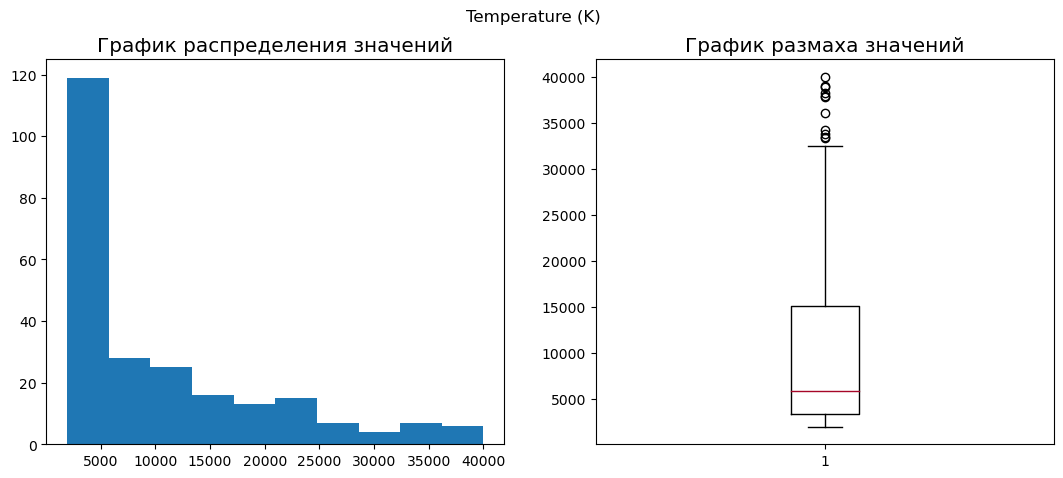

Luminosity(L/Lo) \n
count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64


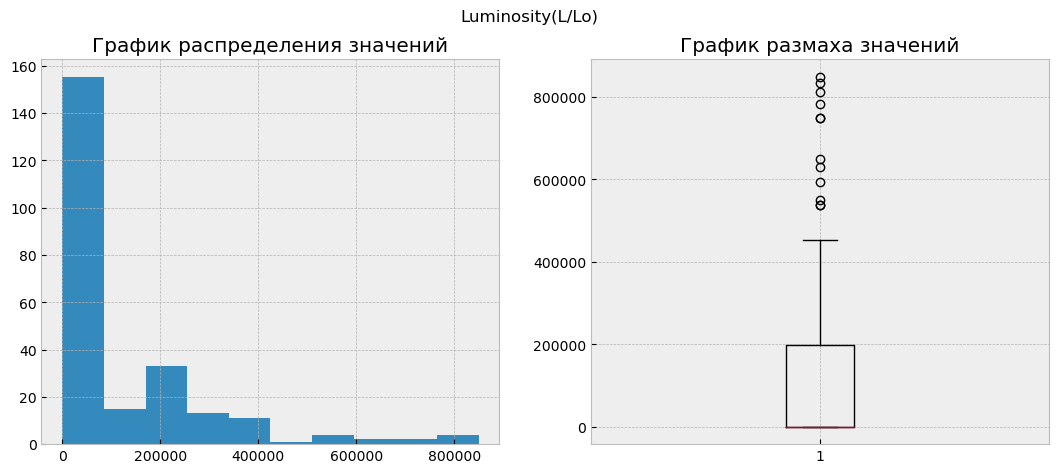

Radius(R/Ro) \n
count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64


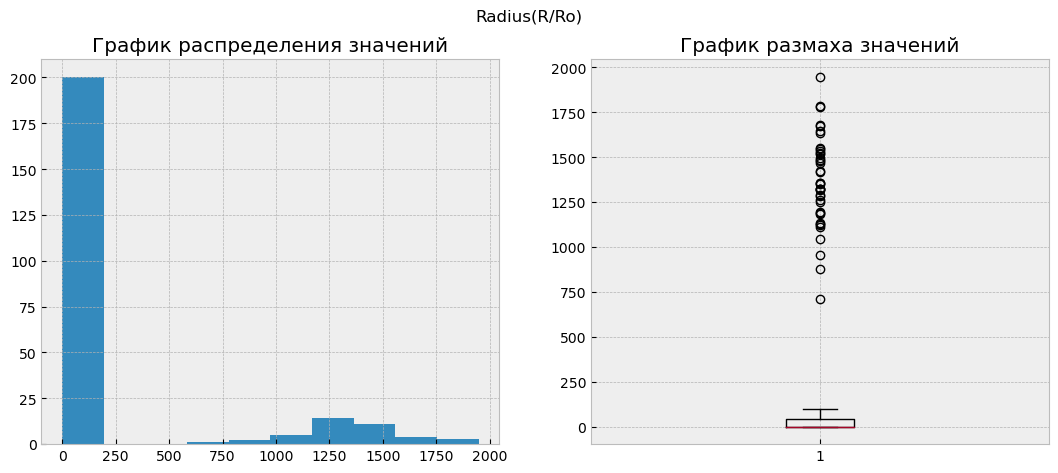

Absolute magnitude(Mv) \n
count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: Absolute magnitude(Mv), dtype: float64


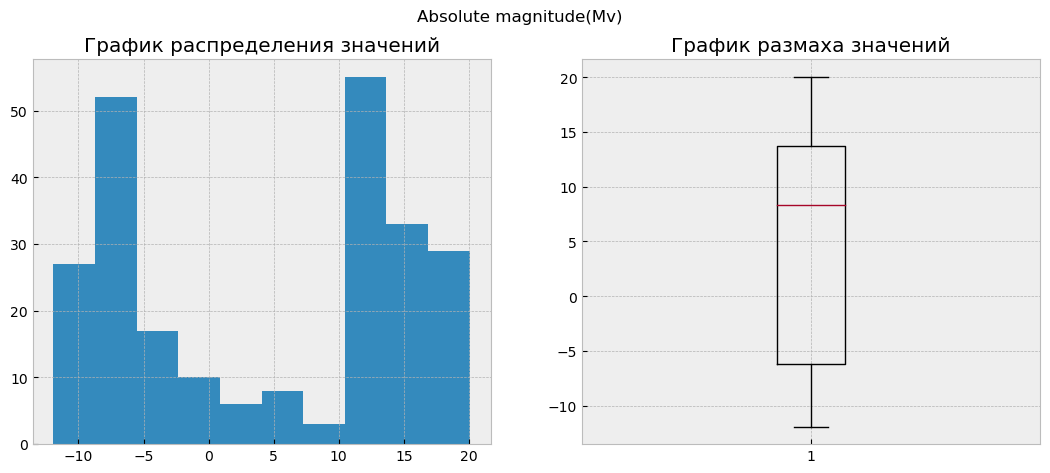

In [7]:
for col in numeric:
    num(col)

### Выводы по количестенным признакам

1. Основная масса представленных температур звезд находится в диапозоне до 6и тысяч. Низкая представленность других объектов.
2. По светимости ситуация похожая, больше половины объектов практически не имеют светимости.
3. Почти 90% объектов имеют радиус меньше 250, представленнось других объектов минимальна.
4. Масса звезд распределенна округ двух показателей: около -7 и около 12.

In [8]:
def cat(column):
    print(column, '\\n')
    print(df[column].value_counts())

    names = list(df[column].value_counts().index)
    values = list(df[column].value_counts().values)

    figure, axis = plt.subplots(figsize=(5, 5))

    axis.barh(names, values)

    plt.style.use('bmh')

    figure.suptitle(column)
    plt.show()

In [9]:
categorical = ['Star type', 'Star color']

In [10]:
df['Star color'] = df['Star color'].str.lower().str.strip()

In [11]:
df['Star color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

In [12]:
df['Star color'] = df['Star color'].replace({'blue white': 'blue',
                                             'yellowish white': 'yellow',
                                             'pale yellow orange': 'yellow',
                                             'blue-white': 'blue',
                                             'whitish': 'white',
                                             'yellow-white': 'yellow',
                                             'white-yellow': 'yellow',
                                             'yellowish': 'yellow',
                                             'orange-red': 'red'})

Star type \n
0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64


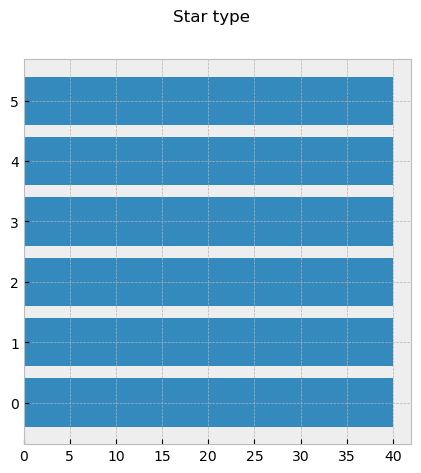

Star color \n
red       113
blue       97
yellow     16
white      12
orange      2
Name: Star color, dtype: int64


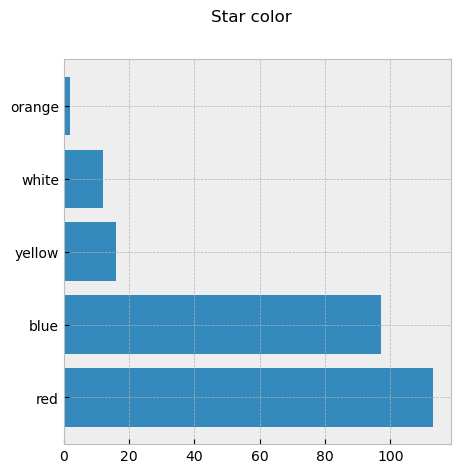

In [13]:
for col in categorical:
    cat(col)

### Выводы по категориальным признакам

1. Распределение объектов по типу является равномерным.
2. 90% объектов являются голубыми или красными планетами.

In [14]:
y = df["Temperature (K)"]
X = df.drop("Temperature (K)", axis=1)

In [15]:
X['Star color'] = OrdinalEncoder().fit_transform(X[['Star color']])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True)

In [17]:
scaler = StandardScaler()
columns_X = X.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=columns_X)
X_test = pd.DataFrame(X_test, columns=columns_X)

del scaler
del columns_X

In [18]:
X_train_tensor = torch.FloatTensor(X_train.values) 
X_test_tensor = torch.FloatTensor(X_test.values)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

### Выводы по данным

Колличество данных является небольшим и большенство из их признаков сконцентрированны у одних показателей, что может негативно сказаться на качестве предсказаний у объектов с низкой представленностью.

## Построение базовой нейронной сети

In [19]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [20]:
def init_weights(layer):
    if type(layer) == nn.Linear: 
        nn.init.normal_(layer.weight, mean=0.0, std=1.14)
        nn.init.normal_(layer.bias, mean=-0.5, std=1.0)

In [21]:
n_in_neurons = 5
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 10
n_out_neurons = 1 

In [22]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

In [23]:
def train_first_model(num_epochs, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    results_loss_1 = [] 
    results_time_1 = [] 
    results_loss_2 = []

    net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
    net.apply(init_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.2)
    loss = nn.MSELoss()
    
    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()
        preds = net.forward(X_train_tensor).flatten()
            
        loss_value = loss(preds, y_train_tensor)
        loss_value.backward()
        optimizer.step()

        with torch.no_grad():   
                net.eval()
                test_preds = net.forward(X_test_tensor).flatten()
                loss_value_test = loss(test_preds, y_test_tensor) 
                print('epoch {}, RMSE train {:.4f}, RMSE test {:.4f}'.format(epoch, torch.Tensor.sqrt_(loss_value),\
                                                                                torch.Tensor.sqrt_(loss_value_test)))                
                
                results_loss_1.append(loss_value.tolist())
                results_time_1.append(epoch)
                results_loss_2.append(loss_value_test.tolist())
                    
    results_loss_1 = pd.Series(results_loss_1)
    results_time_1 = pd.Series(results_time_1)
    results_loss_2 = pd.Series(results_loss_2)

    best_idx = results_loss_2.idxmin()

    print('')
    print('Лучшее значение RMSE test: ', results_loss_2[best_idx])
    print('RMSE train: ', results_loss_1[best_idx])
    print('Epoch: ', results_time_1[best_idx])

    build_graphic(y_test, test_preds)

In [ ]:
train_first_model(num_epochs=10_000, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, X_test_tensor=X_test_tensor, y_test_tensor=y_test_tensor)

Лучшее значение RMSE test:  5184.53271484375
RMSE train:  3375.9296875
Epoch:  194

### Выводы по бэйзлайну,

Базоная нейронная сеть быстро обучается и показывает хорошие результаты на тестовой выборке.
Скорость обучения достигается за счет небольшого количества данных и небольшого количества признаков.
Можно заметить, что объекты с низкой представленностью в данных показывают худшие результаты, а именно объекты с высокой температурой.

## Улучшение нейронной сети

In [25]:
X_train_n, X_valid_n, y_train_n, y_valid_n = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(X_train_n.shape, y_train_n.shape, X_valid_n.shape, y_valid_n.shape)
X_train_n_tensor = torch.FloatTensor(X_train_n.values) 
X_valid_n_tensor = torch.FloatTensor(X_valid_n.values)
y_train_n_tensor = torch.FloatTensor(y_train_n.values)
y_valid_n_tensor = torch.FloatTensor(y_valid_n.values)

(153, 5) (153,) (39, 5) (39,)


In [26]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout1, dropout2):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

In [27]:
def train_second_model(num_epochs, X_train_n_tensor, y_train_n_tensor, X_valid_n_tensor, y_valid_n_tensor, dos):
        results_loss_1 = [] 
        results_time_1 = [] 
        results_loss_2 = []
        do1 = []
        do2 = []
        preds_2 = []

        for v1 in dos:
                for v2 in dos:
                        net2 = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, v1, v2)
                        net2.apply(init_weights)

                        optimizer = torch.optim.Adam(net2.parameters(), lr=0.2)
                        loss = nn.MSELoss()

                        for epoch in range(num_epochs):
                                net2.train()
                                optimizer.zero_grad()
                                preds = net2.forward(X_train_n_tensor).flatten()
                                
                                loss_value = loss(preds, y_train_n_tensor)
                                loss_value.backward()
                                optimizer.step()

                                with torch.no_grad():   
                                        net2.eval()
                                        valid_preds = net2.forward(X_valid_n_tensor).flatten()
                                        loss_value_valid = loss(valid_preds, y_valid_n_tensor) 
                                        print('Do1 {}, Do2 {}, epoch {}, RMSE train {:.4f}, RMSE valid {:.4f}'.format(v1, v2, epoch, torch.Tensor.sqrt_(loss_value),\
                                                torch.Tensor.sqrt_(loss_value_valid)))                
                                
                                        
                                        results_loss_1.append(loss_value.tolist())
                                        results_time_1.append(epoch)
                                        results_loss_2.append(loss_value_valid.tolist())
                                        do1.append(v1)
                                        do2.append(v2)
                                        preds_2.append(valid_preds)

        results_loss_1 = pd.Series(results_loss_1)
        results_time_1 = pd.Series(results_time_1)
        results_loss_2 = pd.Series(results_loss_2)
        do1 = pd.Series(do1)
        do2 = pd.Series(do2)

        best_idx = results_loss_2.idxmin()
                
        print('')
        print('Лучшее значение RMSE valid: ', results_loss_2[best_idx])
        print('RMSE train: ', results_loss_1[best_idx])
        print('Dropout 1: ', do1[best_idx])
        print('Dropout 2: ', do2[best_idx])
        print('Epoch: ', results_time_1[best_idx])

        build_graphic(y_valid_n, preds_2[best_idx])

In [ ]:
train_second_model(num_epochs=10_000, X_train_n_tensor=X_train_n_tensor, y_train_n_tensor=y_train_n_tensor, X_valid_n_tensor=X_valid_n_tensor, y_valid_n_tensor=y_valid_n_tensor, dos=[0.1, 0.2, 0.3, 0.5, 0.8])

Лучшее значение RMSE valid:  4219.44091796875
RMSE train:  2756.937255859375
Dropout 1:  0.8
Dropout 2:  0.5
Epoch:  8230

### Выводы по модели с подбором Дропаута

Из-за применения дропаута, модель использует в 3 раза больше эпох для обучения, но показывает немногого улучшенные показатели ошибки на валидационной выборке при дропауте в 10%.
Проблема с низкой представленностью объектов также влияет на качество предсказаний.

In [29]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

In [30]:
def train_third_model(bs, num_epochs, X_train_n_tensor, y_train_n_tensor, X_valid_n_tensor, y_valid_n_tensor):
    results_loss_3 = []
    results_time_3 = []
    results_size_3 = []
    result_loss_value_3 = []
    preds_3 = []

    net3 = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
    net3.apply(init_weights)

    optimizer = torch.optim.Adam(net3.parameters(), lr=0.2)
    loss = nn.MSELoss()


    for batch_size in bs:
        num_batches = ceil(len(X_train_n_tensor)/batch_size)

        for epoch in range(num_epochs):
            order = np.random.permutation(len(X_train_n_tensor))
            net3.train()
            optimizer.zero_grad()
            for batch_i in range(num_batches):
                start_index = batch_i * batch_size
                
                batch_indexes = order[start_index:start_index+batch_size]
                X_batch = X_train_n_tensor[batch_indexes]
                y_batch = y_train_n_tensor[batch_indexes]
            
                preds = net3.forward(X_batch) 
                        
                loss_value = loss(preds, y_batch)
                loss_value.backward()
                optimizer.step()

                with torch.no_grad():
                        
                            net3.eval()
                            valid_preds = net3.forward(X_valid_n_tensor).flatten()
                            loss_value_valid = loss(valid_preds, y_valid_n_tensor)

                            print('size {}, epoch {}, RMSE train {:.4f}, RMSE valid {:.4f}'.format(batch_size, epoch, \
                                    torch.Tensor.sqrt_(loss_value), torch.Tensor.sqrt_(loss_value_valid)))
                            
                            results_loss_3.append(loss_value_valid.tolist())
                            result_loss_value_3.append(loss_value.tolist())
                            results_time_3.append(epoch)
                            results_size_3.append(batch_size)
                            preds_3.append(valid_preds)

    results_loss_3 = pd.Series(results_loss_3)
    result_loss_value_3 = pd.Series(result_loss_value_3)
    results_time_3 = pd.Series(results_time_3)
    results_size_3 = pd.Series(results_size_3)

    best_idx = results_loss_3.idxmin()


    print('')
    print('Лучшее значение RMSE valid: ', results_loss_3[best_idx])
    print('RMSE train: ', result_loss_value_3[best_idx])
    print('Epoch: ', results_time_3[best_idx])
    print('Batch size: ', results_size_3[best_idx])

    build_graphic(y_valid_n, preds_3[best_idx])

In [ ]:
train_third_model(num_epochs=10_000, X_train_n_tensor=X_train_n_tensor,y_train_n_tensor=y_train_n_tensor, X_valid_n_tensor=X_valid_n_tensor, y_valid_n_tensor=y_valid_n_tensor, bs=[5, 10, 25, 100])

Лучшее значение RMSE valid:  6282.962890625
RMSE train:  6024.45068359375
Epoch:  2171
Batch size:  5

### Выводы по модели с подбором размера батч
    
Из-за использования батчей модель показывает худшие результаты на валидационной выборке, чем без батчей. Скорее всего это связано с распределением признаков. Они влияют и на другие архитектуры, но, возможно, на подход с батчами сильнее всего.

## Выводы

In [35]:
final_epoches = 8230

final_net = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.ELU(),
            nn.Dropout(p=.8),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ELU(),
            nn.Dropout(p=.5),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
            nn.ReLU()
        )

final_net.apply(init_weights)
optimizer = torch.optim.Adam(final_net.parameters(), lr=.2)
loss = nn.MSELoss()

In [36]:
for epoch in range(final_epoches):
    final_net.train()
    optimizer.zero_grad()
    final_train_preds = final_net.forward(X_train_tensor).flatten()
    
    loss_value = loss(final_train_preds, y_train_tensor)
    loss_value.backward()
    optimizer.step()

In [37]:
final_net.eval()
final_test_preds = final_net.forward(X_test_tensor).flatten()
loss_value_valid = loss(final_test_preds, y_test_tensor) 
print('Финальное значение RMSE : ', torch.Tensor.sqrt_(loss_value_valid))

Финальное значение RMSE :  tensor(8641.4502, grad_fn=<SqrtBackward0>)


Основной критерий влияющий на качество оценки модели это представленность объектов в данных. Объекты редко представленные в датасете показывают худшие результаты. Если и в будущем объектов, с которыми нужно работать, будет не много, то стоит усложнить модель и подобрать новые гиперпараметры для улучшения качества предсказаний.